In [78]:
import yfinance as yf
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

In [79]:
nvda = yf.Ticker("NVDA")
nvda_data = nvda.history(period="5y")

df = nvda_data[["Close"]]
df.index = pd.to_datetime(df.index.date)

train_df = df.iloc[:-30]
test_df = df.iloc[-30:]

In [80]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train_df, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_df, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [81]:
auto = auto_arima(df, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7397.048, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7400.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7399.856, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7399.696, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7398.974, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7398.616, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7398.424, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7400.945, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7400.653, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7401.350, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7401.538, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7400.305, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7396.055, Time=1.59 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7396.141, Time=2.18 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

In [82]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import numpy as np

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")
# Mean squared error: 0.34238951346274243
# SMAPE: 0.9825490519101439

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean squared error: 33.766853224224256
SMAPE: 3.0202960401995234


<AxesSubplot: ylabel='Close'>

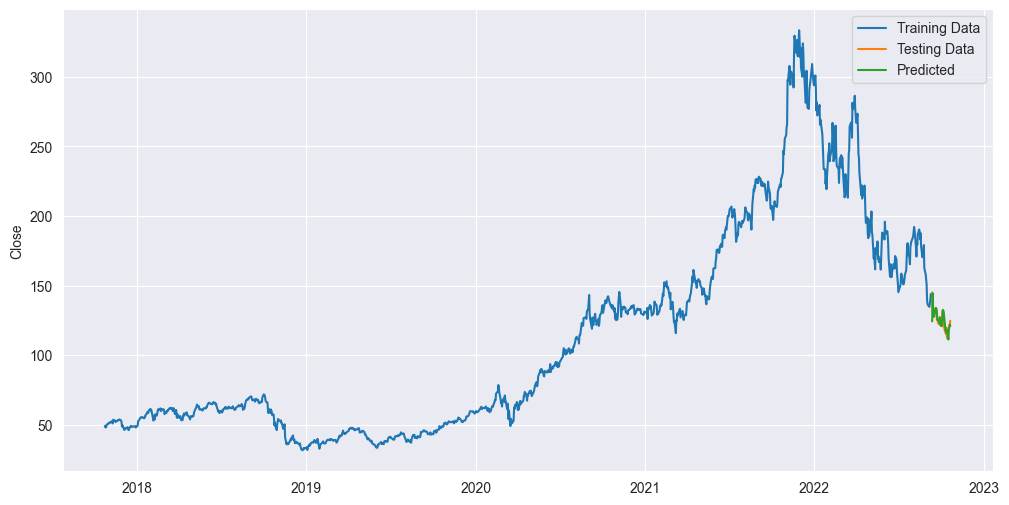

In [83]:

y_train = train_df['Close']
y_test = test_df['Close']

# --------------------- Actual vs. Predicted --------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(train_df,x=train_df.index,y='Close', label='Training Data')
sns.lineplot(test_df,x=test_df.index,y='Close', label='Testing Data')
sns.lineplot(test_df,x = test_df.index, y=forecasts, label='Predicted')



In [87]:
preds = (model.predict(n_periods=12))

predicted_df = pd.DataFrame(preds, columns=['Predicted'])
predicted_df.index = pd.date_range(start='2022-10-24', periods=12, freq='D')

predicted_df

,Predicted
2022-10-24,123.263952
2022-10-25,122.476954
2022-10-26,123.918907
2022-10-27,124.828577
2022-10-28,124.930755
2022-10-29,123.443305
2022-10-30,122.808573
2022-10-31,123.384268
2022-11-01,124.805485
2022-11-02,125.016372
